## Imports

In [2]:
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from PIL import Image
from time import perf_counter
from sklearn.decomposition.pca import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold

## Setup

In [45]:
random_state = 12345
np.random.seed( random_state )

def get_directory_list( data_dir ):
    return [ d for d in os.listdir( data_dir ) if d != '.DS_Store' and d != 'README' ]


data_dir = 'dataset/intel_images/full'
#data_dir = 'C:\\Users\\dryyo\\Documents\\Homework\\Senior Year\\Machine Learning\\tmp\\dog vs cat\\dataset\\training_set'
dir_list = get_directory_list( data_dir )
print(dir_list)

def get_random_numbers( n , min_inclusive , max_inclusive ):
    return np.random.randint( max_inclusive + 1 , size=n )

def update_runtimes( runtimes , label , val , type ):
    for i in range(len(runtimes)):
        if runtimes[i]['label'] == label:
            runtimes[i]['val'] = val
            return runtimes
    runtimes.append( { 'label':label , 'val':val , 'type':type } )
    return runtimes


runtimes = list( ) 
n              = 5
min_inclusive  = 0
max_inclusive  = 10
sample_indices = get_random_numbers( n , min_inclusive , max_inclusive )
print( sample_indices )

def get_file_list( data_dir , dir_list , n_per_class=50 ):
    all_files = list()
    for d in dir_list:
        files = [ data_dir + '/' + d + '/' + f for f in os.listdir( data_dir + '/' + d ) ]
        all_files += np.random.choice(files, n_per_class).tolist()
    return all_files


t0 = perf_counter( )
file_list = get_file_list( data_dir , dir_list , n_per_class=50 )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'File List Construction' , ( t1 - t0 ) , 0 )


print( 'File List:\n' , file_list[:10] )

def get_data_dimensions( file_list ):
    return np.shape( Image.open( file_list[0] ).convert( "L" ) )


t0 = perf_counter( )
H , W = get_data_dimensions( file_list )
#H = H//5
#W = W//5
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Dimension Extraction' , ( t1 - t0 ) , 0 )

print( 'Shape = %d x %d => %d Pixels' % ( H , W , H*W ) )
print(len(file_list))


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
[2 5 1 4 9]
File List:
 ['dataset/intel_images/full/buildings/13079.jpg', 'dataset/intel_images/full/buildings/14318.jpg', 'dataset/intel_images/full/buildings/612.jpg', 'dataset/intel_images/full/buildings/21291.jpg', 'dataset/intel_images/full/buildings/16988.jpg', 'dataset/intel_images/full/buildings/15675.jpg', 'dataset/intel_images/full/buildings/12263.jpg', 'dataset/intel_images/full/buildings/23628.jpg', 'dataset/intel_images/full/buildings/10695.jpg', 'dataset/intel_images/full/buildings/2478.jpg']
Shape = 150 x 150 => 22500 Pixels
300


## Create and Show Image Array

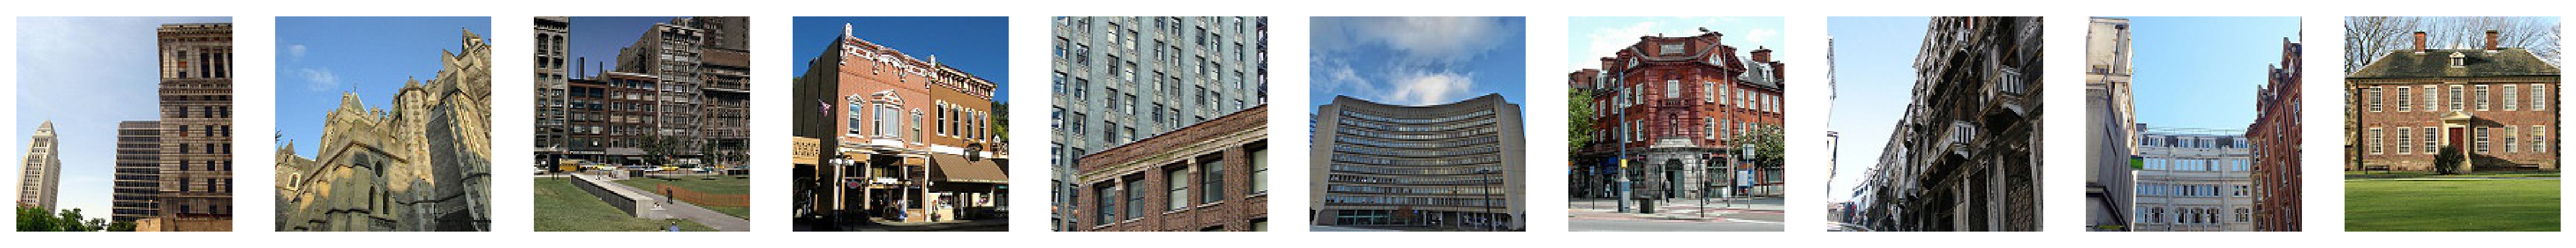

In [46]:
def image_grid( D , H , W , cols=10 , scale=1 ):
    n    = np.shape( D )[0]
    rows = int( math.ceil( ( n + 0.0 ) / cols ) )
    fig  = plt.figure( 1 , figsize=[ scale * 20.0/H * W , scale * 20.0/cols * rows ] , dpi=300 )
    for i in range( n ):
        plt.subplot( rows , cols , i + 1 )
        fig = plt.imshow( np.reshape( D[i,:] , [H,W,3] ).astype( int ) )
        plt.axis( 'off' )
    plt.show( )
    
    
def create_images_array( file_list , H , W ):
    im_number = len( file_list )
    arr       = np.zeros( [ im_number , H * W * 3 ] )
    for i in range( im_number ):
        im = Image.open( file_list[i] ).convert("RGB")
        if np.shape( im ) != ( H , W ):
            im = im.resize( ( W , H ) )
        arr[i,:] = np.reshape( np.asarray( im ) , [ 1 , H * W * 3 ] )
    return arr


# === Call create_images_array On file_list === #
t0 = perf_counter( )
arr = create_images_array( file_list , H , W )
t1 = perf_counter( )
runtimes = update_runtimes( runtimes , 'Data Read' , ( t1 - t0 ) , 0 )


# === Show Successful Load by Displaying First 10 in Image Grid === #
image_grid( arr[:10] , H , W )


## -------------------------------------------Multiclass Classification------------------------------------------------

Compute Mean Image

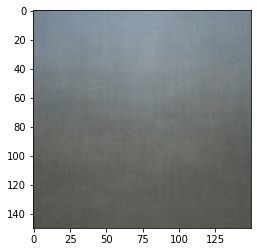

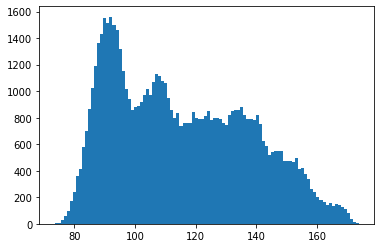

In [47]:
def get_mean_image( arr ):
    return np.mean( arr , axis=0 )


mean_image = get_mean_image( arr )

def plot_single_image( image , H , W ):
    plt.imshow( np.reshape( image , [H,W,3] ).astype( int ) )
    plt.figure( )
    plt.hist( image , bins=100 )
    plt.show( )
    return

plot_single_image( mean_image , H , W )

# looks like the mean photo has a light source about where the sun would be

## Normalize Dataset

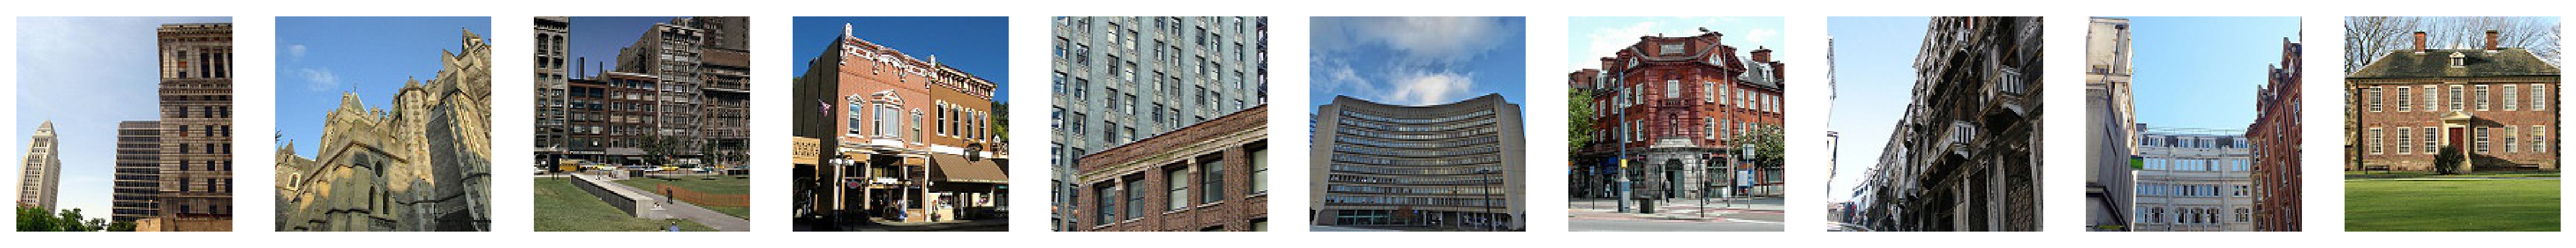

In [48]:
def normalize_image_data( image_array , mean_image ):
    return image_array - mean_image


arr_norm = normalize_image_data( arr , mean_image )

# Display the First 10 Normalized Images
image_grid( np.abs(arr_norm[:10,:]) , H , W )

## PCA and Eigenvalues

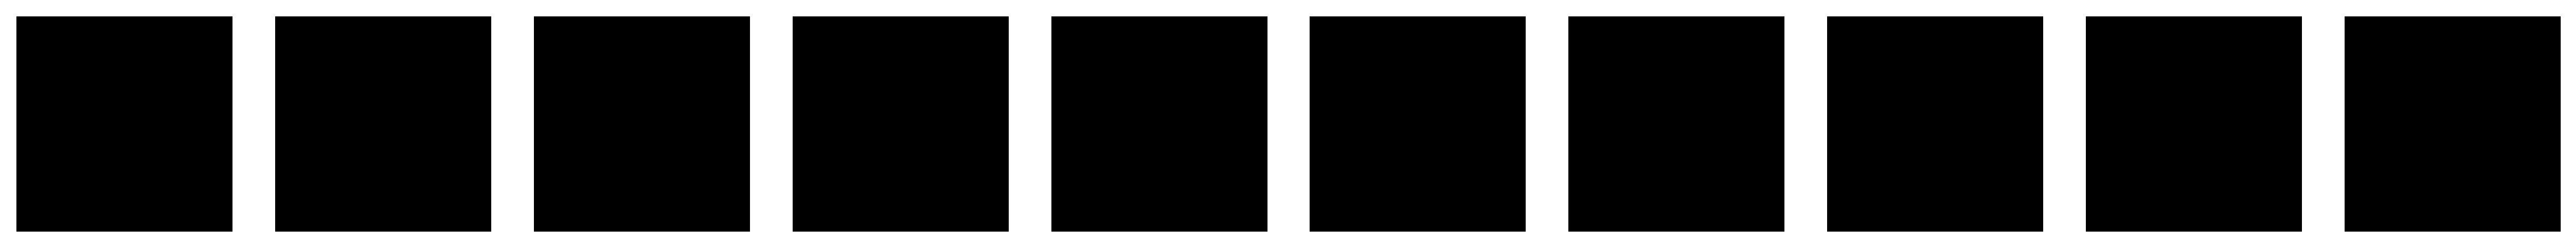

Number of Eigenvalues:  (250,)


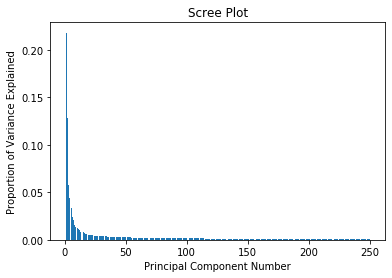

Components After Cut:  140
Number of Eigenvalues:  (140,)


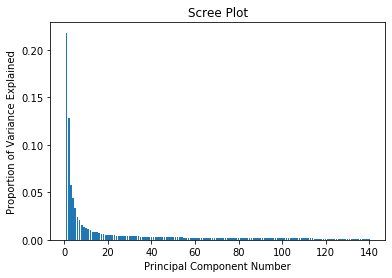

['dataset/intel_images/full/buildings/13079.jpg', 'dataset/intel_images/full/buildings/14318.jpg', 'dataset/intel_images/full/buildings/612.jpg', 'dataset/intel_images/full/buildings/21291.jpg', 'dataset/intel_images/full/buildings/16988.jpg', 'dataset/intel_images/full/buildings/15675.jpg', 'dataset/intel_images/full/buildings/12263.jpg', 'dataset/intel_images/full/buildings/23628.jpg', 'dataset/intel_images/full/buildings/10695.jpg', 'dataset/intel_images/full/buildings/2478.jpg']
['buildings' 'buildings' 'buildings' 'buildings' 'buildings' 'buildings'
 'buildings' 'buildings' 'buildings' 'buildings']
X Train Shape: (240, 140)
y Train Shape: (240,)
X Test Shape:  (60, 140)
y Test Shape:  (60,)
KNN (k=5) Cumulative Test Accuracy Score: 0.30000000

0.3


In [55]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=250, n_iter=10, random_state=random_state)
svd.fit(arr_norm)
def get_eigens(fit_svd):
    return fit_svd.components_
eigens = get_eigens(svd)
image_grid( eigens[:10,:] , H , W )

def plot_eigenvalues( fit_svd , pve=None ):
    if type( pve ) == type( None ):
        pve = fit_svd.explained_variance_ratio_
    print( 'Number of Eigenvalues: ' , pve.shape )
    plt.bar( x=range( 1 , len( pve ) + 1 ) , height=pve )
    plt.title( "Scree Plot" )
    plt.ylabel( "Proportion of Variance Explained" )
    plt.xlabel( "Principal Component Number" )
    plt.show( )
plot_eigenvalues( svd )
def cut_eigens( fit_svd , variance_thresh ):
    eigenfaces = fit_svd.components_
    pve        = fit_svd.explained_variance_ratio_
    variance   = 0
    for i in range( len( pve ) ):
        variance += pve[i]
        if variance >= variance_thresh:
            break
    return i , pve[:i+1] , eigens[:i+1]
cut_level , new_eigenvalues , new_eigenfaces = cut_eigens( svd , 0.90 )
print( 'Components After Cut: ' , len( new_eigenvalues ) )
plot_eigenvalues( svd , new_eigenvalues )

def construct_X_y( data_norm , eigenfaces , data_dir , file_list ):
    X = np.dot( data_norm , eigenfaces.T )
    y = list( )
    for f in file_list:
        tmp = f.replace( data_dir , '' )[1:]
        y.append( tmp[:tmp.index( '/' )] )
    return X , np.array( y )
X , y = construct_X_y( arr_norm , new_eigenfaces , data_dir , file_list )
print(file_list[:10])
print(y[:10])
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,stratify=y)
print( 'X Train Shape:' , X_train.shape )
print( 'y Train Shape:' , y_train.shape )
print( 'X Test Shape: ' , X_test.shape )
print( 'y Test Shape: ' , y_test.shape )

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
#rfc = RandomForestClassifier()
#rfc.fit(X_train,y_train)

#dtc = DecisionTreeClassifier()
#dtc.fit(X_train, y_train)

svc = SVC(gamma='scale', kernel='sigmoid')
svc.fit(X_train, y_train)
#knn = KNeighborsClassifier(1)
#knn.fit(X_train, y_train)
my_model = svc

def get_accuracy_scores( X_train , X_test , y_train , y_test , eigenfaces , mean_image , scores=dict( ) , model=None ):
    # Fit model if none exists
    if type( model ) == type( None ):
        model = KNeighborsClassifier( 1 )
        model.fit( X_train , y_train )
        
    # Overall Accuracy 
    acc = model.score( X_test , y_test )
    
    # Compare Test Prediction to Truth to get Per-Class
    y_pred = model.predict( X_test )
    for i in range( len( y_test ) ):
        update = ( 0 , 1 )
        if y_test[i] == y_pred[i]:
            update = ( 1 , 1 )
#        else:
#            print('FALSE PREDICTION -- Truth={} , Predicted={}'.format(y_test[i],y_pred[i]))
#            false_pred = np.dot(X_test[i,:], eigenfaces) + mean_image
#            false_pred = X_test[i] + mean_image
#            plot_single_image( false_pred , 150 , 150 )
        if y_test[i] in scores.keys( ):
            scores[y_test[i]] = ( scores[y_test[i]][0] + update[0] , scores[y_test[i]][1] + update[1] )
        else:
            scores[y_test[i]] = update
            
    return acc , scores


# print_scores_per_subject
def print_scores_per_subject( scores ):
    mean = lambda score: score[0] / score[1]
    key  = lambda x: int( x[1:] )
    for subject in sorted( scores.keys( ) , key=key ):
        print( '%3s: %.8f' % ( subject , mean( scores[subject] ) ) )
    

# Extract the Accuracy Scores
acc_knn , scores_knn = get_accuracy_scores( X_train , X_test , y_train , y_test , new_eigenfaces , mean_image , model=my_model )

# Print the Accuracy Score
print( 'KNN (k=5) Cumulative Test Accuracy Score: %0.8f\n' % acc_knn )
print(my_model.score(X_test,y_test))

In [56]:
pca = PCA()
pca.fit(arr_norm)

def get_eigens(fit_pca):
    return fit_pca.components_


eigens = get_eigens( pca )
print(eigens[:10])

[[-4.60746580e-03 -5.46974556e-03 -6.63837806e-03 ... -2.47544595e-03
  -2.80430242e-03 -3.14832203e-03]
 [-2.83039356e-03 -2.91657022e-03 -2.34079017e-03 ...  4.72931755e-03
   4.72387661e-03  5.19293865e-03]
 [ 5.36449845e-03  3.84253012e-03  1.75646000e-03 ...  6.39328131e-03
   6.00811966e-03  5.05204919e-03]
 ...
 [ 4.73300417e-03  6.17400210e-03  6.07260664e-03 ...  4.10641199e-03
   5.18019756e-03  5.49373946e-03]
 [-4.54179372e-05 -2.53511503e-04  7.30216427e-04 ... -4.69844604e-03
  -5.90570666e-03 -7.23793678e-03]
 [ 1.46939730e-03  4.66678797e-03  9.16978799e-03 ...  3.17059836e-04
  -2.14044358e-03 -4.68092008e-03]]


Number of Eigenvalues:  (300,)


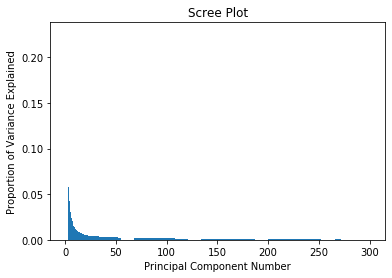

Components After Cut:  139
Number of Eigenvalues:  (139,)


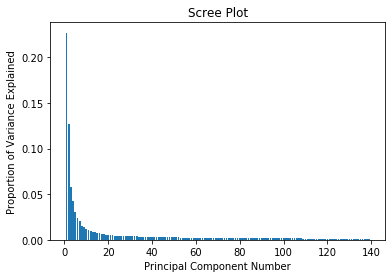

In [57]:
def plot_eigenvalues( fit_pca , pve=None ):
    if type( pve ) == type( None ):
        pve = fit_pca.explained_variance_ratio_
    
    print( 'Number of Eigenvalues: ' , pve.shape )
    plt.bar( x=range( 1 , len( pve ) + 1 ) , height=pve )
    plt.title( "Scree Plot" )
    plt.ylabel( "Proportion of Variance Explained" )
    plt.xlabel( "Principal Component Number" )
    plt.show( )


# === Plot the Eigenvalues to Satisfy Assignment Specs === #
plot_eigenvalues( pca )


def cut_eigens( fit_pca , variance_thresh ):
    eigenfaces = fit_pca.components_
    pve        = fit_pca.explained_variance_ratio_
    variance   = 0
    for i in range( len( pve ) ):
        variance += pve[i]
        if variance >= variance_thresh:
            break
    return i , pve[:i+1] , eigens[:i+1]


# === Cut the Eigens for the Fit Data, Satisfying Assignment Specs === #
cut_level , new_eigenvalues , new_eigenfaces = cut_eigens( pca , 0.90 )

# === Show-Off the Cut by Displaying a New Scree Plot === #
print( 'Components After Cut: ' , len( new_eigenvalues ) )
plot_eigenvalues( pca , new_eigenvalues )

In [58]:
def construct_X_y( data_norm , eigenfaces , data_dir , file_list ):
    X = np.dot( data_norm , eigenfaces.T )
#    X = data_norm.copy()
    y = list( )
    for f in file_list:
        tmp = f.replace( data_dir , '' )[1:]
        y.append( tmp[:tmp.index( '/' )] )
    return X , np.array( y )


# === Construct X and y === #
X , y = construct_X_y( arr_norm , new_eigenfaces , data_dir , file_list )

# === Partion X and y with an 80:20 Split === #
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state,stratify=y)

# === Output the Shapes of the Train and Test Datasets === #
print( 'X Train Shape:' , X_train.shape )
print( 'y Train Shape:' , y_train.shape )
print( 'X Test Shape: ' , X_test.shape )
print( 'y Test Shape: ' , y_test.shape )

X Train Shape: (240, 139)
y Train Shape: (240,)
X Test Shape:  (60, 139)
y Test Shape:  (60,)


In [59]:
knn = KNeighborsClassifier(1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [70]:
test = np.array([arr[0]])
test_pca = pca.transform(test)
test_eigs = test_pca[:,:len(X_train[0])]
print(test.shape)
print(test_pca.shape)
print(test_eigs.shape)
print(X_train.shape)
pred = knn.predict(test_eigs)
print(pred)

(1, 67500)
(1, 300)
(1, 139)
(240, 139)
['forest']


In [54]:
def get_accuracy_scores2( X_train , X_test , y_train , y_test , eigenfaces , mean_image , scores=dict( ) , model=None ):
    # Fit model if none exists
    if type( model ) == type( None ):
        model = KNeighborsClassifier( 1 )
        model.fit( X_train , y_train )
        
    # Overall Accuracy 
    acc = model.score( X_test , y_test )
    
    # Compare Test Prediction to Truth to get Per-Class
    y_pred = model.predict( X_test )
    for i in range( len( y_test ) ):
        update = ( 0 , 1 )
        if y_test[i] == y_pred[i]:
            update = ( 1 , 1 )
#        else:
#            print('FALSE PREDICTION -- Truth={} , Predicted={}'.format(y_test[i],y_pred[i]))
#            false_pred = np.dot(X_test[i,:], eigenfaces) + mean_image
#            plot_single_image( false_pred , 150 , 150 )
        if y_test[i] in scores.keys( ):
            scores[y_test[i]] = ( scores[y_test[i]][0] + update[0] , scores[y_test[i]][1] + update[1] )
        else:
            scores[y_test[i]] = update
            
    return acc , scores


# print_scores_per_subject
def print_scores_per_subject( scores ):
    mean = lambda score: score[0] / score[1]
    key  = lambda x: int( x[1:] )
    for subject in sorted( scores.keys( ) , key=key ):
        print( '%3s: %.8f' % ( subject , mean( scores[subject] ) ) )
    

# Extract the Accuracy Scores
acc_knn , scores_knn = get_accuracy_scores2( X_train , X_test , y_train , y_test , new_eigenfaces , mean_image , model=knn )

# Print the Accuracy Score
print( 'KNN (k=1) Cumulative Test Accuracy Score: %0.8f\n' % acc_knn )

KNN (k=1) Cumulative Test Accuracy Score: 0.35000000



In [ ]:
def kfold_cross_validation( X , k ):
    kf               = KFold( k , shuffle=True , random_state=random_state )
    accuracies_kfold = list( )
    scores_kfold     = dict( )
    for train_index , test_index in kf.split( X ):
        X_fold_train = X[train_index]
        X_fold_test  = X[test_index]
        y_fold_train = y[train_index]
        y_fold_test  = y[test_index]
        acc_kfold, scores_kfold  = get_accuracy_scores(X_fold_train, X_fold_test, y_fold_train,y_fold_test, scores=scores_kfold) 
        accuracies_kfold.append( acc_kfold )
    return sum( accuracies_kfold ) / len( accuracies_kfold ) , scores_kfold

    
# Perform a 5-Fold Cross Validation and Get Accuracies
k = 5
acc_kfold,scores_kfold = kfold_cross_validation( X , k )

# Display the Accuracy
print( 'Accuracy: %.8f' % acc_kfold )

In [ ]:
# === New Desired Dimensions Hard-Coded In === #
H_resize = 75
W_resize = 75
print( 'New Dimensions: %d x %d => %d pixels' % ( H_resize , W_resize , H_resize * W_resize ) )

# === Extract Image Array with these New Dimensions === #
arr_resize = create_images_array( file_list , H_resize , W_resize )

# === Show Image Grid to Confirm Successful Resizing === #
image_grid(arr_resize[:10,:],H_resize,W_resize)

In [ ]:
mean_image_resize = get_mean_image( arr_resize )
plot_single_image( mean_image_resize , H_resize , W_resize )

In [ ]:
arr_norm_resize = normalize_image_data( arr_resize , mean_image_resize )
image_grid(arr_norm_resize[:10,:],H_resize,W_resize)

In [ ]:
pca_resize = PCA( )
pca_resize.fit( arr_norm_resize )

In [ ]:
# === Get the Resized Eigenfaces === #
eigenfaces_resize = pca_resize.components_ #get_eigenfaces( pca_resize )
print( 'Resized Eigenfaces Shape: ' , eigenfaces_resize.shape )

# === Plot the Resized Eigenfaces to Confirm Success === #
image_grid( eigenfaces_resize[:100,:] , H_resize , W_resize )

In [ ]:
plot_eigenvalues( pca_resize )

In [ ]:
cut_level_resize , new_eigenvalues_resize , new_eigenfaces_resize = cut_eigens( pca_resize , 0.90 )

# === Show Cut Metrics and Re-Plot Eigenvalues === #
print( 'Components After Cut: ' , len( new_eigenvalues_resize ) )
plot_eigenvalues( pca_resize , new_eigenvalues_resize )

In [ ]:
X_resize, y_resize = construct_X_y(arr_norm_resize, new_eigenfaces_resize, data_dir, file_list)

# === 80:20 Train Test Split === #
test_size = 0.2
X_train_resize, X_test_resize, y_train_resize, y_test_resize = train_test_split(X_resize,y_resize,test_size=test_size, random_state=random_state,stratify=y)

# === Report the Shapes of the Partitions === #
print( 'X Train Shape:' , X_train_resize.shape )
print( 'y Train Shape:' , y_train_resize.shape )
print( 'X Test Shape: ' , X_test_resize.shape )
print( 'y Test Shape: ' , y_test_resize.shape )

In [ ]:
knn_resize = KNeighborsClassifier( 1 )
knn_resize.fit( X_train_resize , y_train_resize )

In [ ]:
# === Get the Accuracy Scores === #
acc_knn_resize, scores_knn_resize = get_accuracy_scores(X_train_resize, X_test_resize, y_train_resize, y_test_resize, model=knn_resize)

# === Report the Accuracy Scores === #
print('KNN (k=1) Cumulative Test Accuracy Score: %0.8f' % acc_knn_resize)